# Inf2 - Foundations of Data Science
# Topic: Linear Models

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy
import scipy.stats

In [2]:
## Set the DPI for higher quality output
matplotlib.rcParams['savefig.dpi'] = 300

## Correlations and squirrel data

In [3]:
# Read data
dat = pd.read_csv('squirrel-clean.csv')
dat["Year"].value_counts()

1985    35
1986    30
Name: Year, dtype: int64

Separate female and male data, and plot female data.

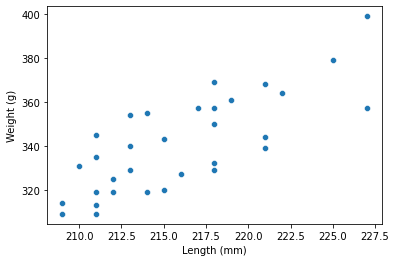

In [4]:
datf = dat[dat['Sex'] == 'F']
datm = dat[dat['Sex'] == 'M']

ax = sns.scatterplot(x='Length (mm)', y='Weight (g)', data=datf)

ax.get_figure().savefig('squirrel-height-weight.pdf')
ax.get_figure().savefig('squirrel-height-weight.png')

Pandas has handy functions for computing the correlation coefficient. We'll compute the coefficients of weight and height for females, males, and all the squirrels.

In [5]:
datf['Weight (g)'].corr(datf['Length (mm)'])

0.7723934330499515

In [6]:
datm['Weight (g)'].corr(datm['Length (mm)'])

0.6690522604322643

In [7]:
dat['Weight (g)'].corr(dat['Length (mm)'])

0.7083024821943226

## Anscombe's quartet

In [8]:
dat = pd.read_csv('anscombe.csv')
dat[['x', 'y1', 'y2', 'y3']].corr()

,x,y1,y2,y3
x,1.000000,0.816421,0.816237,0.816287
y1,0.816421,1.000000,0.750005,0.468717
y2,0.816237,0.750005,1.000000,0.587919
y3,0.816287,0.468717,0.587919,1.000000


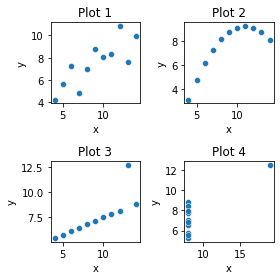

In [9]:
(fig, ax) = plt.subplots(2,2, figsize=(4, 4))
sns.scatterplot(x='x', y='y1', data=dat, ax=ax[0][0])
ax[0][0].set_title('Plot 1')
ax[0][0].set_ylabel('y')

sns.scatterplot(x='x', y='y2', data=dat, ax=ax[0][1])
ax[0][1].set_title('Plot 2')
ax[0][1].set_ylabel('y')

sns.scatterplot(x='x', y='y3', data=dat, ax=ax[1][0])
ax[1][0].set_title('Plot 3')
ax[1][0].set_ylabel('y')

sns.scatterplot(x='x4', y='y4', data=dat, ax=ax[1][1])
ax[1][1].set_title('Plot 4')
ax[1][1].set_xlabel('x')
ax[1][1].set_ylabel('y')


plt.tight_layout()
fig.savefig("anscombe.pdf")
fig.savefig('anscombe.png')

## Heights data and regression

In [10]:
# Load the data
heights = pd.read_csv('galton.csv')
heights.head()

,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,78.5,67.0,75.43,4,1,male,73.2
1,1,78.5,67.0,75.43,4,2,female,69.2
2,1,78.5,67.0,75.43,4,3,female,69.0
3,1,78.5,67.0,75.43,4,4,female,69.0
4,2,75.5,66.5,73.66,4,1,male,73.5


Plot the heights, using hue to distinguish gender.

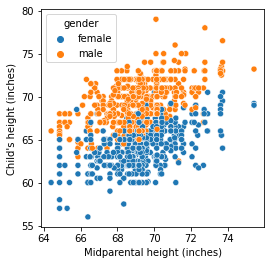

In [11]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(x='midparentHeight', y='childHeight', hue='gender', hue_order=['female', 'male'], data=heights)
plt.xlabel('Midparental height (inches)')
plt.ylabel("Child's height (inches)")
# fig.gca().set_aspect('equal')
fig.savefig('heights.png')
fig.savefig('heights.pdf')

## Regression as prediction

This is the implementation of a method that predicts the height of a child of a parent of height $x$ by taking the mean height of children whose parents had heights in the range $[x-0.5, x+0.5]$.

In [12]:
def predict_child_height(x, heights):
    return(heights.loc[(heights['midparentHeight'] > x - 0.5) &
                        (heights['midparentHeight'] < x + 0.5),
                        'childHeight'].mean())

In [13]:
heights_f = heights[heights['gender'] == 'female'].copy().drop(['family', 'gender'], axis=1)
x = np.arange(64,77, 0.25)
yhat = [predict_child_height(xp, heights_f) for xp in x]

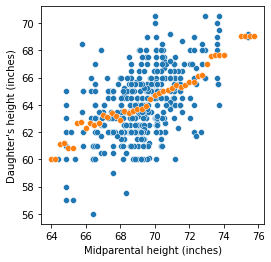

In [14]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(x='midparentHeight', y='childHeight', data=heights_f)
# fig.gca().set_aspect('equal')
plt.xlabel('Midparental height (inches)')
plt.ylabel("Daughter's height (inches)")
fig.savefig('heights-female.png')
sns.scatterplot(x=x, y=yhat)
fig.savefig('heights-female-predictions.pdf')
fig.savefig('heights-female.predictions.png')

## Linear regression

First let's define regression and prediction functions. In real life we'd use a package, e.g. Seaborn (for integration with graphics) or scikit-learn (for larger applications) to run the regression.

In [15]:
def regression(x, y):
    x = np.array(x)
    y = np.array(y)
    xbar = np.mean(x)
    ybar = np.mean(y)
    Sxy = np.sum((x - xbar) * (y - ybar))
    Sxx = np.sum((x - xbar) * (x - xbar))
    beta1 = Sxy/Sxx
    beta0 = np.mean(y) - beta1*np.mean(x)
    return((beta0, beta1))

def prediction(x, beta0, beta1):
    x = np.array(x)
    return(beta0 + beta1*x)

def R2(y, yhat):
    SST = np.sum(np.power(y - y.mean(), 2))
    SSE = np.sum(np.power(y - yhat, 2))
    return((SST - SSE)/SST)

def MSE(y, yhat):
    return(1/len(y)*np.sum(np.power(y - yhat, 2)))

def RMSE(y, yhat):
    return(np.sqrt(MSE(y, yhat)))

Now we'll regress the daughters' heights on the parents' heights.

In [16]:
x = heights_f['midparentHeight']
y = heights_f['childHeight']
beta0, beta1 = regression(x, y)
yhat = prediction(x, beta0, beta1)
type(R2(y, yhat))

numpy.float64

In [17]:
print('R2 = %0.2f, r^2 = %0.2f, r = %2.2f, MSE = %2.2f, RMSE = %2.2f' % 
      (R2(y, yhat), np.power(y.corr(x), 2), y.corr(x), MSE(y, yhat), RMSE(y, yhat)))

R2 = 0.26, r^2 = 0.26, r = 0.51, MSE = 4.08, RMSE = 2.02


Plot, showing the mean.

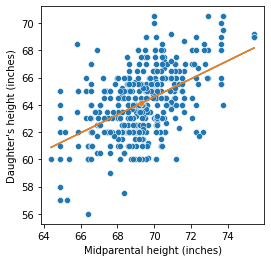

In [18]:
fig = plt.figure(figsize=(4, 4))
# Plot data
sns.scatterplot(x='midparentHeight', y='childHeight', data=heights_f)
# Plot mean
sns.scatterplot(x='midparentHeight', y='childHeight', data=pd.DataFrame(heights_f.mean()).transpose())
# Plot fit
sns.lineplot(x=[], y=[])
sns.lineplot(x=x, y=yhat)
sns.lineplot(x=x, y=yhat)

# fig.gca().set_aspect('equal')
plt.xlabel('Midparental height (inches)')
plt.ylabel("Daughter's height (inches)")
fig.savefig('heights-female-linear-regression.pdf')
fig.savefig('heights-female-linear-regression.png')

## Regression with standardised variables

We'll use a function to standardise:

In [19]:
def standardise(x):
    return((x - x.mean())/x.std())

heights_f['standardisedMidparentHeight'] = standardise(heights_f['midparentHeight'])
heights_f['standardisedChildHeight'] = standardise(heights_f['childHeight'])

Now we'll regress childHeight on MidparentHeight:

In [20]:
x_s = heights_f['standardisedMidparentHeight']
y_s = heights_f['standardisedChildHeight']
beta0_yonx, beta1_yonx = regression(x_s, y_s)
print(beta0_yonx, beta1_yonx)

2.8621234693244765e-16 0.5132725171879096


Note that $\hat\beta_0$ is almost 0 - that's because the standardisation has shifted the location of the mean to (0, 0). Note that $\hat\beta_1$ is less than 1, as it should be.

We'll now regress $x$ on $y$, i.e. try to predict the midparental height from the Daughter's height.

In [21]:
beta0_xony, beta1_xony = regression(y_s, x_s)
print(beta0_xony, beta1_xony)

-3.843866995462897e-15 0.5132725171879096


We have the same value of $\hat\beta_1$, which is exactly the same as the correlation coefficient.

0.26344867690041285
0.263448676900413


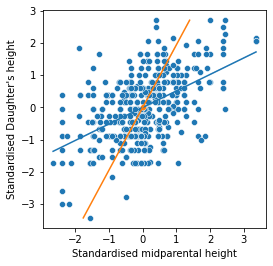

In [22]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(x='standardisedMidparentHeight', y='standardisedChildHeight', data=heights_f)
## sns.scatterplot(x='midparentHeight', y='childHeight', data=pd.DataFrame(heights_f.mean()).transpose())
sns.scatterplot(x=[0], y=[0])
yhat_s = prediction(x_s, 0, beta1_yonx)
xhat_s = prediction(y_s, 0, beta1_xony)
sns.lineplot(x=[], y=[])
sns.lineplot(x=x_s, y=yhat_s)
sns.lineplot(x=xhat_s, y=y_s)

# fig.gca().set_aspect('equal')
plt.xlabel('Standardised midparental height')
plt.ylabel("Standardised Daughter's height")
fig.savefig('heights-female-linear-regression-standardised.pdf')
fig.savefig('heights-female-linear-regression-standardised.png')

print(R2(y_s, yhat_s))
print(np.power(x_s.corr(y_s),2))

## Residuals

### Residual plot

In [23]:
heights_f['Residuals'] = y - yhat

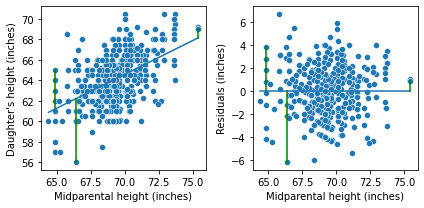

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
sns.scatterplot(x='midparentHeight', y='childHeight', data=heights_f, ax=ax[0])
sns.lineplot(x=[], y=[], ax=ax[0]) # Dummy plot to set the colour
sns.lineplot(x=x, y=yhat, ax=ax[0])

x = np.array(x)
y = np.array(y)

ax[0].plot([x[2], x[2]], [y[2], yhat[2]], color='green')
ax[0].plot([x[405], x[405]], [y[405], yhat[405]], color='green')
ax[0].plot([x[338], x[338]], [y[338], yhat[338]], color='green')

ax[0].set_xlabel('Midparental height (inches)')
ax[0].set_ylabel("Daughter's height (inches)")

sns.scatterplot(x='midparentHeight', y='Residuals', data=heights_f, ax=ax[1])
yhat = prediction(x, beta0, beta1)
sns.lineplot(x=[], y=[], ax=ax[1]) # Dummy plot to set the colour
sns.lineplot(x=x, y=0*x, ax=ax[1])
epsilon = np.array(heights_f['Residuals'])
ax[1].plot([x[2], x[2]], [0, epsilon[2]], color='green')
ax[1].plot([x[405], x[405]], [0, epsilon[405]], color='green')
ax[1].plot([x[338], x[338]], [0, epsilon[338]], color='green')


# fig.gca().set_aspect('equal')
ax[1].set_xlabel('Midparental height (inches)')
ax[1].set_ylabel('Residuals (inches)')
plt.tight_layout() # Prevent overlapping labels

fig.savefig('heights-female-residuals.pdf')
fig.savefig('heights-female-residuals.png')

### Nonlinearity

In [25]:
# worldpop = pd.read_csv('world-population.csv')
# worldpop2020 = worldpop[worldpop['Year'] <= 2020]
# sns.scatterplot(x='Year', y='Population', data=worldpop2020)

In [26]:
hyde = pd.read_excel('pop_summary_tcm61-44258.xlsx')
hyde.dtypes

Global historical population estimates 10k BC - 2 k AD (in millions)     object
Unnamed: 1                                                               object
Unnamed: 2                                                               object
Unnamed: 3                                                               object
Unnamed: 4                                                               object
                                                                         ...   
Unnamed: 58                                                             float64
Unnamed: 59                                                             float64
Unnamed: 60                                                             float64
Unnamed: 61                                                              object
Unnamed: 62                                                              object
Length: 63, dtype: object

In [27]:
worldpop = hyde.iloc[[1, 36,], 1:43].transpose().astype('float')
worldpop.columns = ['Year', 'Population (millions)']
worldpop = worldpop.reset_index(drop=True)
worldpop1500 = worldpop[worldpop['Year'] > 1930].copy()

0.9753703425310537


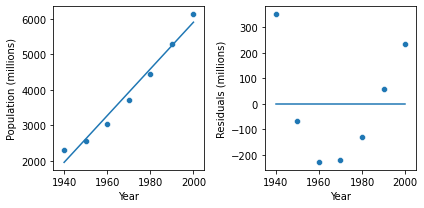

In [28]:
x = worldpop1500['Year']
y = worldpop1500['Population (millions)']
beta0, beta1 = regression(x, y)
yhat = prediction(x, beta0, beta1)


fig, ax = plt.subplots(1, 2, figsize=(6, 3))
sns.scatterplot(x='Year', y='Population (millions)', data=worldpop1500, ax=ax[0])
sns.lineplot(x=[], y=[], ax=ax[0])
sns.lineplot(x=x, y=yhat, ax=ax[0])
ax[0].set_xlim([1935, 2005])


sns.scatterplot(x='Year', y=y - yhat, data=worldpop1500, ax=ax[1])
sns.lineplot(x=[], y=[], ax=ax[1])
sns.lineplot(x=x, y=x*0, ax=ax[1])
ax[1].set_ylabel('Residuals (millions)')
ax[1].set_xlim([1935, 2005])
plt.tight_layout() # Prevent overlapping labels
fig.savefig('world-population.pdf')
fig.savefig('world-population.png')

print(R2(y, yhat))

0.9952435089752641


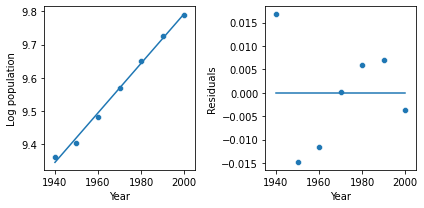

In [29]:
worldpop1500['LogPopulation'] = [np.log10(x) + 6 for x in worldpop1500['Population (millions)']]
x = worldpop1500['Year']
y = worldpop1500['LogPopulation']
beta0, beta1 = regression(x, y)
yhat = prediction(x, beta0, beta1)

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
sns.scatterplot(x='Year', y='LogPopulation', data=worldpop1500, ax=ax[0])
sns.lineplot(x=[], y=[], ax=ax[0])
sns.lineplot(x=x, y=yhat, ax=ax[0])
ax[0].set_ylabel('Log population')
ax[0].set_xlim([1935, 2005])


sns.scatterplot(x='Year', y=y - yhat, data=worldpop1500, ax=ax[1])
sns.lineplot(x=[], y=[], ax=ax[1])
sns.lineplot(x=x, y=x*0, ax=ax[1])
fig.gca().set_ylabel('Residuals')
ax[1].set_xlim([1935, 2005])


plt.tight_layout() # Prevent overlapping labels
fig.savefig('world-population-log.pdf')
fig.savefig('world-population-log.png')

print(R2(y, yhat))

In [30]:
(np.power(10, 0.015) - 1) * 2000

70.28433335868777

In [31]:
worldpop1500['Population (millions)'].apply(lambda x: np.log10(x), 0)

35    3.363113
36    3.405667
37    3.483273
38    3.569355
39    3.649404
40    3.724898
41     3.78851
Name: Population (millions), dtype: object

## Heteroscedasticity

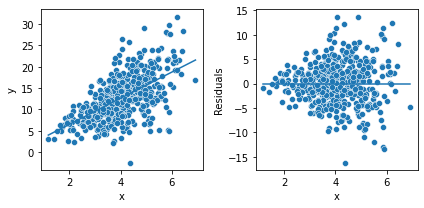

In [32]:
n = 500
x = scipy.stats.distributions.norm.rvs(size=n) + 4
y = x*3 + 0.5-x*scipy.stats.distributions.norm.rvs(size=n)
beta0, beta1 = regression(x, y)
yhat = prediction(x, beta0, beta1)

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

sns.scatterplot(x=x, y=y, ax=ax[0])
sns.lineplot(x=[], y=[], ax=ax[0])
sns.lineplot(x=x, y=yhat, ax=ax[0])
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')

sns.scatterplot(x=x, y=y - yhat, ax=ax[1])
sns.lineplot(x=[], y=[], ax=ax[1])
sns.lineplot(x=x, y=x*0, ax=ax[1])
ax[1].set_xlabel('x')
ax[1].set_ylabel('Residuals')

plt.tight_layout() # Prevent overlapping labels
plt.savefig('heteroscedasticity.png')
plt.savefig('heteroscedasticity.pdf')

### Squirrel e.g. for nonlinearity?

<AxesSubplot:xlabel='Length (mm)', ylabel='Residuals (g)'>

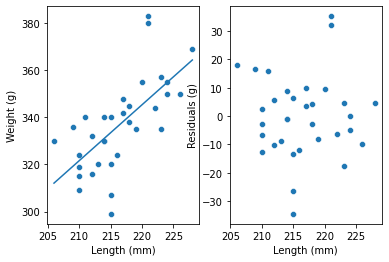

In [33]:
dat = pd.read_csv('squirrel-clean.csv')
dat['CRWeight (g^1/3)'] = dat['Weight (g)'].apply(lambda x: np.power(x, 1/3))
datf = dat[dat['Sex'] == 'F'].copy()
datm = dat[dat['Sex'] == 'M'].copy()


x = datm['Length (mm)']
y = datm['Weight (g)']
beta0, beta1 = regression(x, y)
yhat = prediction(x, beta0, beta1)
datm['Residuals (g)'] = y - yhat

fig, ax = plt.subplots(1, 2)
sns.scatterplot(x='Length (mm)', y='Weight (g)', data=datm, ax=ax[0])
sns.lineplot(x=x, y=yhat, ax=ax[0])
sns.scatterplot(x='Length (mm)', y='Residuals (g)', data=datm)

<AxesSubplot:xlabel='Length (mm)', ylabel='CRResiduals (g^1/3)'>

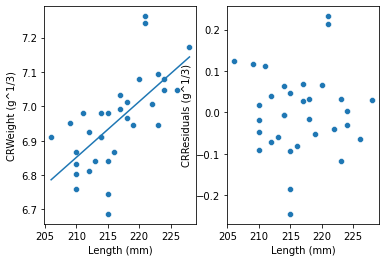

In [34]:
x = datm['Length (mm)']
y = datm['CRWeight (g^1/3)']
beta0, beta1 = regression(x, y)
yhat = prediction(x, beta0, beta1)
datm['CRResiduals (g^1/3)'] = y - yhat

fig, ax = plt.subplots(1, 2)
sns.scatterplot(x='Length (mm)', y='CRWeight (g^1/3)', data=datm, ax=ax[0])
sns.lineplot(x=x, y=yhat, ax=ax[0])
sns.scatterplot(x='Length (mm)', y='CRResiduals (g^1/3)', data=datm)